In [1]:
import os
os.chdir('../')

In [2]:
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score
from src.utils import flatten, get_segments
from src.segmentation import ImobsSegmentation

In [3]:
df_preds = (
    pd.read_csv("notebooks/outputs/df_preds_2.csv")
    .rename(columns={"dt_calendar": "dt_ativacao"})
)
df_preds["dt_ativacao"] = pd.to_datetime(df_preds["dt_ativacao"]).dt.strftime("%Y-%m")

print(df_preds.shape)
df_preds.head()

,dt_ativacao,id_imobiliaria,predictions,target,old_segments
0,2021-12,38,0.057598,0,C
1,2021-12,50,0.069909,0,D
2,2021-12,63,0.058328,0,C
3,2021-12,81,0.208023,0,E
4,2021-12,95,0.074017,0,D


In [4]:
partitioner = ImobsSegmentation()
partitioner.fit(df_preds)

OptimalBinning(gamma=0.5, max_n_bins=3, min_n_bins=3, name='score_imobiliaria',
               solver='mip')

In [5]:
print(f"Splits: {partitioner.splits}")
partitioner.binning_table()

Splits: [0.04163761 0.06624058]


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.04)",687,0.310158,683,4,0.005822,1.450858,0.351083,0.040401
1,"[0.04, 0.07)",1047,0.472686,1029,18,0.017192,0.356629,0.050939,0.006334
2,"[0.07, inf)",481,0.217156,449,32,0.066528,-1.048055,0.403311,0.048226
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,2215,1.000000,2161,54,0.024379,,0.805334,0.094961


In [6]:
df_preds = partitioner.get_optimal_segments(df_preds)

df_preds["old_transformed_segments"] = (
    df_preds["old_segments"]
    .replace(['B', 'C', 'D'],'B')
    .replace('E', 'C')
)

df_preds.head()

,dt_ativacao,id_imobiliaria,predictions,target,old_segments,optimal_bins,optimal_segments,old_transformed_segments
0,2021-12,38,0.057598,0,C,0.017192,2-medio,B
1,2021-12,50,0.069909,0,D,0.066528,3-alto,B
2,2021-12,63,0.058328,0,C,0.017192,2-medio,B
3,2021-12,81,0.208023,0,E,0.066528,3-alto,C
4,2021-12,95,0.074017,0,D,0.066528,3-alto,B


In [7]:
# Segmentação ótima
partitioner.calculate_auc_among_segments(df_preds)
partitioner.calculate_auc_within_segments(df_preds, "optimal_bins")

AUC among segments:               
- Optimal segments: 0.727

AUC within segments (mean): 0.582


,rating,auc
0,0.005822,0.694
1,0.017192,0.498
2,0.066528,0.553


In [8]:
df_preds.to_csv(f"notebooks/outputs/df_bins_2.csv", index=False)

In [8]:
# Segmentação ótima
partitioner.calculate_auc_among_segments(df_preds)
partitioner.calculate_auc_within_segments(df_preds, "optimal_bins")

AUC among segments:               
- Optimal segments: 0.78

AUC within segments (mean): 0.502


,rating,auc
0,0.001813,0.522
1,0.022315,0.470
2,0.055794,0.513


In [8]:
# Segmentação antiga
partitioner.calculate_auc_among_segments(df_preds, "old_segments")
partitioner.calculate_auc_within_segments(df_preds, "old_segments")

AUC among segments:               
- Optimal segments: 0.78
- Alternative segments: 0.758

AUC within segments (mean): 0.64


,rating,auc
0,A,0.483
1,B,0.798
2,C,0.799
3,D,0.524
4,E,0.596


In [9]:
# Segmentação antiga considerando ratings B-C-D como um único
partitioner.calculate_auc_among_segments(df_preds, "old_transformed_segments")
partitioner.calculate_auc_within_segments(df_preds, "old_transformed_segments")

AUC among segments:               
- Optimal segments: 0.78
- Alternative segments: 0.698

AUC within segments (mean): 0.62


,rating,auc
0,A,0.483
1,B,0.780
2,C,0.596


In [10]:
df_preds.groupby(["old_transformed_segments"])["target"].mean()

old_transformed_segments
A    0.002899
B    0.012364
C    0.045936
Name: target, dtype: float64

In [9]:
df_preds.groupby(["optimal_bins", "optimal_segments"])["target"].mean()

optimal_bins  optimal_segments
0.020465      1-baixo             0.020465
0.080169      2-medio             0.080169
0.235088      3-alto              0.235088
Name: target, dtype: float64

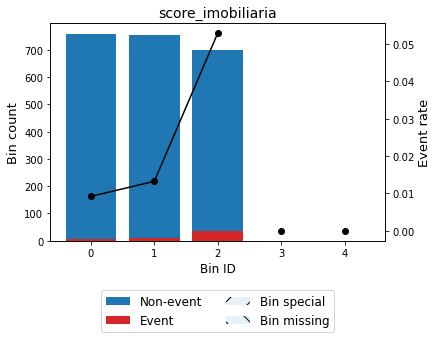

In [13]:
partitioner.binning_table(mode="plot")

In [12]:
partitioner.binning_table(mode="analysis")

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.56452255
    IV (Jeffrey)             1.36538633
    JS (Jensen-Shannon)      0.15366609
    Hellinger                0.16152052
    Triangular               0.56355265
    KS                       0.49032411
    HHI                      0.39385408
    HHI (normalized)         0.24231760
    Cramer's V               0.31780543
    Quality score            0.01119286

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic      p-value     P[A > B]  P[B > A]
        0      1    10.187867 1.413678e-03 1.432947e-04  0.999857
        1      2    97.133726 6.479971e-23 1.768614e-34  1.000000



/Users/raquel.camara/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
